# **Importing the modules**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection
from sklearn.ensemble import StackingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import matthews_corrcoef
from category_encoders import WOEEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, StratifiedKFold, LeaveOneOut, cross_validate
import pickle
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# **Load dataset**

In [2]:
ML_data = pd.read_csv("ML_UG_dataset.csv", sep = ",")
Val_data = pd.read_csv("ML_SA_dataset.csv", sep = ",")
print(ML_data.shape)
print(ML_data.dtypes)
ML_data.head(2)

(182, 5003)
Unnamed: 0      int64
Sample         object
HIV STATUS      int64
AGE             int64
SEX             int64
                ...  
POS_4408920     int64
POS_4408923     int64
POS_4409954     int64
POS_4410386     int64
POS_4411016     int64
Length: 5003, dtype: object


,Unnamed: 0,Sample,HIV STATUS,AGE,SEX,STM,INH,RIF,EMB,POS_371,...,POS_4407873,POS_4407927,POS_4408048,POS_4408087,POS_4408156,POS_4408920,POS_4408923,POS_4409954,POS_4410386,POS_4411016
0,0,ERR038736,0,30,0,0,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,ERR038737,0,23,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0


# **Converting the columns to the correct data types**

In [3]:
# Select columns with the common prefix 'POS'
pos_columns = ML_data.filter(like='POS')

# Convert selected columns to categorical
ML_data[pos_columns.columns] = pos_columns.astype('category')

ML_data['RIF']= ML_data['RIF'].astype('category')
ML_data['INH']= ML_data['INH'].astype('category')
ML_data['STM']= ML_data['STM'].astype('category')
ML_data['EMB']= ML_data['EMB'].astype('category')


In [4]:
# Select columns with the common prefix 'POS'
pos_columns = Val_data.filter(like='POS')

# Convert selected columns to categorical
Val_data[pos_columns.columns] = pos_columns.astype('category')

Val_data['RIF']= Val_data['RIF'].astype('category')
Val_data['INH']= Val_data['INH'].astype('category')
Val_data['STM']= Val_data['STM'].astype('category')
Val_data['EMB']= Val_data['EMB'].astype('category')

# **Missing value check**

In [5]:
ML_data.isna().sum()

Unnamed: 0     0
Sample         0
HIV STATUS     0
AGE            0
SEX            0
              ..
POS_4408920    0
POS_4408923    0
POS_4409954    0
POS_4410386    0
POS_4411016    0
Length: 5003, dtype: int64

In [6]:
Val_data.isna().sum()

Unnamed: 0     0
Sample         0
AGE            0
SEX            0
HIV STATUS     2
              ..
POS_4408920    0
POS_4408923    0
POS_4409954    0
POS_4410386    0
POS_4411016    0
Length: 5003, dtype: int64

# **Seperating the Features and target**

In [7]:
# Remove columns starting with 'POS'
#ML_data = ML_data.loc[:, ~ML_data.columns.str.startswith('POS')]


In [8]:
Columns_to_be_deleted= ['Sample', 'Unnamed: 0', 'RIF', 'STM', 'INH', 'SEX', 'AGE', 'HIV STATUS']

EMB_data = ML_data.drop( Columns_to_be_deleted, axis=1)

X= EMB_data.drop('EMB', axis=True)
Y= EMB_data['EMB']

X.shape, Y.shape



((182, 4994), (182,))

In [9]:
X.head()

,POS_371,POS_1228,POS_1552,POS_1849,POS_1977,POS_2532,POS_3446,POS_4013,POS_5078,POS_6112,...,POS_4407873,POS_4407927,POS_4408048,POS_4408087,POS_4408156,POS_4408920,POS_4408923,POS_4409954,POS_4410386,POS_4411016
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
Y.value_counts()

0    118
1     64
Name: EMB, dtype: int64

In [11]:
Columns_to_be_deleted= ['Unnamed: 0', 'RIF', 'STM', 'INH', 'SEX', 'AGE', 'HIV STATUS']

In [12]:
Val_data = Val_data.drop( Columns_to_be_deleted, axis=1)

In [13]:
X_val= Val_data.drop('EMB', axis=True)
Y_val= Val_data['EMB']

X_val.shape, Y_val.shape


((238, 4995), (238,))

In [14]:
Y_val.value_counts()

1    130
0    108
Name: EMB, dtype: int64

# **Splitting the dataset**

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, sample_ids_train, sample_ids_test = train_test_split(X, Y,
                                                                                ML_data['Sample'], 
                                                                                       stratify=Y,
                                                                                       train_size=0.8,
                                                                                       test_size=0.2,
                                                                                    random_state=42)

In [16]:
X_train.shape, X_test.shape

((145, 4994), (37, 4994))

In [17]:
y_train.value_counts()

0    94
1    51
Name: EMB, dtype: int64

In [18]:
y_test.value_counts()

0    24
1    13
Name: EMB, dtype: int64

 # **Initializing the best ML model**

In [62]:
# Initialize CatBoostClassifier
#model_cat = CatBoostClassifier(depth=3, iterations=100, l2_leaf_reg=3, learning_rate = 0.1, verbose=False)
model_xgboost = XGBClassifier(learning_rate=0.3, max_depth=3, n_estimators=100,subsample=1.0,random_state=0)

# **Preparing pipeline steps**

In [63]:
categorical_prefix = 'POS'
categorical_columns = [col for col in X_train.columns if col.startswith(categorical_prefix)]
cat_var = categorical_columns.copy()


In [64]:
print(cat_var)

['POS_371', 'POS_1228', 'POS_1552', 'POS_1849', 'POS_1977', 'POS_2532', 'POS_3446', 'POS_4013', 'POS_5078', 'POS_6112', 'POS_6140', 'POS_6815', 'POS_7362', 'POS_7572', 'POS_7582', 'POS_7585', 'POS_8040', 'POS_8056', 'POS_8452', 'POS_9143', 'POS_9304', 'POS_10741', 'POS_11370', 'POS_11820', 'POS_11879', 'POS_12204', 'POS_13069', 'POS_13298', 'POS_13460', 'POS_14251', 'POS_14401', 'POS_14785', 'POS_14861', 'POS_15117', 'POS_16119', 'POS_17608', 'POS_17609', 'POS_17654', 'POS_21795', 'POS_21819', 'POS_22961', 'POS_23174', 'POS_24007', 'POS_25610', 'POS_26347', 'POS_26747', 'POS_26957', 'POS_26959', 'POS_27439', 'POS_27463', 'POS_27469', 'POS_27487', 'POS_27996', 'POS_28139', 'POS_28366', 'POS_28536', 'POS_28640', 'POS_29482', 'POS_29641', 'POS_30519', 'POS_30688', 'POS_30943', 'POS_31077', 'POS_32103', 'POS_32349', 'POS_32355', 'POS_33436', 'POS_33457', 'POS_33551', 'POS_33670', 'POS_33841', 'POS_34044', 'POS_34527', 'POS_34568', 'POS_34859', 'POS_35097', 'POS_35608', 'POS_36008', 'POS_36

In [24]:
from sklearn.feature_selection import SelectFromModel
#scaler = StandardScaler()
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
#feature = SelectFromModel(model_rf, threshold=0.001)
ct = ColumnTransformer([('onehot', onehot, cat_var)],
                       remainder='passthrough',
                       n_jobs=-1)

# Make Predictions

## Handling for class imbalance

In [25]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled.shape, X_train.shape, y_resampled.shape, y_train.shape

((188, 4994), (145, 4994), (188,), (145,))

In [26]:
# Now you have training and testing sets for features and labels, as well as Sample_IDs
print("Training Sample IDs:\n", sample_ids_train)
print("Testing Sample IDs:\n", sample_ids_test)

Training Sample IDs:
 166    SRR7535060
27      ERR040122
65      ERR987715
49      ERR987697
180    SRR7535093
          ...    
25      ERR040120
101     ERR987755
174    SRR7535078
125     ERR987787
155    SRR7535041
Name: Sample, Length: 145, dtype: object
Testing Sample IDs:
 77      ERR987730
45      ERR040140
162    SRR7535055
136     ERR990540
110     ERR987767
149     ERR990555
59      ERR987709
165    SRR7535059
31      ERR040126
7       ERR038743
32      ERR040127
9       ERR038745
124     ERR987786
36      ERR040131
63      ERR987713
169    SRR7535067
96      ERR987750
97      ERR987751
148     ERR990554
177    SRR7535088
154    SRR7535040
56      ERR987705
69      ERR987720
167    SRR7535064
131     ERR990535
181    SRR7535094
15      ERR038751
8       ERR038744
144     ERR990550
44      ERR040139
161    SRR7535052
60      ERR987710
50      ERR987698
79      ERR987732
104     ERR987759
16      ERR038752
12      ERR038748
Name: Sample, dtype: object


In [38]:
import pandas as pd
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score

# Function to calculate and print metrics
def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = recall_score(y_true, y_pred)  # Sensitivity is the same as recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Calculate specificity
    return sensitivity, specificity

# Store results for benchmarking
results = []
pipe = Pipeline([('ct', ct), ('classifier', model_xgboost)])
# Specify the model you want to use (model_gbc)
#model = model_xgboost

print("Running for model:", model.__class__.__name__)

# Fit the model
pipe.fit(X_resampled, y_resampled)

# Make predictions
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class

# Calculate metrics
sensitivity, specificity = calculate_metrics(y_test, y_pred)

# Append results to the list along with sample IDs
for sample_id, true_label, pred_label in zip(sample_ids_test, y_test, y_pred):
    results.append({
        'Sample_ID': sample_id,
        'True_Label': true_label,
        'ML_Predicted_Label': pred_label,
        #'Model': model.__class__.__name_,
        'Model': 'XGBoost',
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'ROC_AUC': roc_auc_score(y_test, y_proba)  # Calculate ROC AUC here
    })

print("-" * 40)  # Separator for clarity

# Convert results to a DataFrame for easier handling
ML_predictions_UG = pd.DataFrame(results)

# Display results
print(ML_predictions_UG.head())  # Display the first few rows to check the results


Running for model: XGBClassifier


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


----------------------------------------
    Sample_ID  True_Label  ML_Predicted_Label    Model  Sensitivity  \
0   ERR987730           0                   0  XGBoost     0.769231   
1   ERR040140           1                   1  XGBoost     0.769231   
2  SRR7535055           0                   0  XGBoost     0.769231   
3   ERR990540           0                   0  XGBoost     0.769231   
4   ERR987767           0                   0  XGBoost     0.769231   

   Specificity   ROC_AUC  
0     0.916667  0.891026  
1     0.916667  0.891026  
2     0.916667  0.891026  
3     0.916667  0.891026  
4     0.916667  0.891026  


In [39]:
# Display results
ML_predictions_UG.head(n=10)

,Sample_ID,True_Label,ML_Predicted_Label,Model,Sensitivity,Specificity,ROC_AUC
0,ERR987730,0,0,XGBoost,0.769231,0.916667,0.891026
1,ERR040140,1,1,XGBoost,0.769231,0.916667,0.891026
2,SRR7535055,0,0,XGBoost,0.769231,0.916667,0.891026
3,ERR990540,0,0,XGBoost,0.769231,0.916667,0.891026
4,ERR987767,0,0,XGBoost,0.769231,0.916667,0.891026
5,ERR990555,0,0,XGBoost,0.769231,0.916667,0.891026
6,ERR987709,0,0,XGBoost,0.769231,0.916667,0.891026
7,SRR7535059,0,0,XGBoost,0.769231,0.916667,0.891026
8,ERR040126,1,1,XGBoost,0.769231,0.916667,0.891026
9,ERR038743,1,1,XGBoost,0.769231,0.916667,0.891026


In [40]:
X_val.head()

,Sample,POS_371,POS_1228,POS_1552,POS_1849,POS_1977,POS_2532,POS_3446,POS_4013,POS_5078,...,POS_4407873,POS_4407927,POS_4408048,POS_4408087,POS_4408156,POS_4408920,POS_4408923,POS_4409954,POS_4410386,POS_4411016
0,SRR9971303,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,SRR9971318,0,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,SRR9971302,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,SRR9971120,0,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
4,SRR9971317,0,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0


In [41]:
# Extract the 'sample_id' column
sample_val_ids = X_val['Sample'].values  # Accessing 'sample_id' column

# Print the sample IDs
print(sample_val_ids)


['SRR9971303' 'SRR9971318' 'SRR9971302' 'SRR9971120' 'SRR9971317'
 'SRR9971301' 'SRR9971312' 'SRR9971075' 'SRR9971014' 'SRR9971003'
 'SRR9971298' 'SRR11349202' 'SRR9971276' 'SRR11349164' 'SRR9971280'
 'SRR11349142' 'SRR9971008' 'SRR9971310' 'SRR9971047' 'SRR9971204'
 'SRR9971199' 'SRR9971271' 'SRR9971266' 'SRR9971132' 'SRR9971268'
 'SRR9971278' 'SRR9971265' 'SRR9971130' 'SRR9971133' 'SRR9971264'
 'SRR10315458' 'SRR9971267' 'SRR9971081' 'SRR9971078' 'SRR9971196'
 'SRR9971079' 'SRR10315712' 'SRR9971058' 'SRR9971249' 'SRR9971245'
 'SRR10315690' 'SRR9971111' 'SRR9971038' 'SRR9971110' 'SRR9971360'
 'SRR9971116' 'SRR9971309' 'SRR9971361' 'SRR9971307' 'SRR9971362'
 'SRR9971244' 'SRR9971306' 'SRR9971009' 'SRR9971363' 'SRR9971020'
 'SRR9971006' 'SRR9971239' 'SRR9971238' 'SRR9971251' 'SRR9971100'
 'SRR9971018' 'SRR10315750' 'SRR9971364' 'SRR9971286' 'SRR9971214'
 'SRR9971217' 'SRR9971194' 'SRR9971181' 'SRR9971259' 'SRR9971323'
 'SRR9971324' 'SRR9971321' 'SRR9971322' 'SRR9971178' 'SRR9971034'
 'S

In [42]:
import pandas as pd
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score

# Function to calculate and print metrics
def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = recall_score(y_true, y_pred)  # Sensitivity is the same as recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Calculate specificity
    return sensitivity, specificity

# Store results for benchmarking
results = []

# Ensure sample_val_ids is properly extracted
sample_val_ids = X_val['Sample'].values  # Extract sample IDs

# Drop 'sample_id' from X_val to use the rest of the features as predictors
X_val_without_sample_id = X_val.drop(columns=['Sample']) if 'Sample' in X_val.columns else X_val

pipe = Pipeline([('ct', ct), ('classifier', model_xgboost)])
# Fit the model
pipe.fit(X_resampled, y_resampled)

# Make predictions
y_pred = pipe.predict(X_val_without_sample_id)
y_proba = pipe.predict_proba(X_val_without_sample_id)[:, 1]  # Get predicted probabilities for the positive class

# Calculate metrics
sensitivity, specificity = calculate_metrics(Y_val, y_pred)

# Append results to the list along with sample IDs
for sample_id, true_label, pred_label in zip(sample_val_ids, Y_val, y_pred):
    results.append({
        'Sample_ID': sample_id,  # Include sample ID here
        'True_Label': true_label,
        'ML_Predicted_Label': pred_label,
        'Model': 'XGBoost',  # Hard-code the model name (since you are using model_cat)
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'ROC_AUC': roc_auc_score(Y_val, y_proba)  # Calculate ROC AUC here
    })

# Separator for clarity
print("-" * 40)

# Convert results to a DataFrame for easier handling
ML_predictions_SA = pd.DataFrame(results)

# Display results (first 10 rows for preview)
print(ML_predictions_SA.head(n=10))


/home/sandra.babirye/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


----------------------------------------
    Sample_ID  True_Label  ML_Predicted_Label    Model  Sensitivity  \
0  SRR9971303           1                   0  XGBoost     0.507692   
1  SRR9971318           1                   0  XGBoost     0.507692   
2  SRR9971302           0                   0  XGBoost     0.507692   
3  SRR9971120           0                   0  XGBoost     0.507692   
4  SRR9971317           0                   0  XGBoost     0.507692   
5  SRR9971301           1                   0  XGBoost     0.507692   
6  SRR9971312           0                   1  XGBoost     0.507692   
7  SRR9971075           1                   1  XGBoost     0.507692   
8  SRR9971014           1                   1  XGBoost     0.507692   
9  SRR9971003           0                   0  XGBoost     0.507692   

   Specificity   ROC_AUC  
0     0.833333  0.759687  
1     0.833333  0.759687  
2     0.833333  0.759687  
3     0.833333  0.759687  
4     0.833333  0.759687  
5     0.833333 

In [43]:
ML_predictions_SA.head(n=10)

,Sample_ID,True_Label,ML_Predicted_Label,Model,Sensitivity,Specificity,ROC_AUC
0,SRR9971303,1,0,XGBoost,0.507692,0.833333,0.759687
1,SRR9971318,1,0,XGBoost,0.507692,0.833333,0.759687
2,SRR9971302,0,0,XGBoost,0.507692,0.833333,0.759687
3,SRR9971120,0,0,XGBoost,0.507692,0.833333,0.759687
4,SRR9971317,0,0,XGBoost,0.507692,0.833333,0.759687
5,SRR9971301,1,0,XGBoost,0.507692,0.833333,0.759687
6,SRR9971312,0,1,XGBoost,0.507692,0.833333,0.759687
7,SRR9971075,1,1,XGBoost,0.507692,0.833333,0.759687
8,SRR9971014,1,1,XGBoost,0.507692,0.833333,0.759687
9,SRR9971003,0,0,XGBoost,0.507692,0.833333,0.759687


## TB_profiler predictions

In [44]:
tb_profiler_results_UG = pd.read_csv('TBprofiler drug resistance predictions.csv')
tb_profiler_results_UG.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DATA                      226 non-null    object
 1   rifampicin                226 non-null    int64 
 2   isoniazid                 226 non-null    int64 
 3   ethambutol                226 non-null    int64 
 4   pyrazinamide              226 non-null    int64 
 5   streptomycin              226 non-null    int64 
 6   fluoroquinolones          226 non-null    int64 
 7   aminoglycosides           226 non-null    int64 
 8   kanamycin                 226 non-null    int64 
 9   amikacin                  226 non-null    int64 
 10  capreomycin               226 non-null    int64 
 11  ethionamide               226 non-null    int64 
 12  para-aminosalicylic_acid  226 non-null    int64 
 13  clofazimine               226 non-null    int64 
 14  linezolid                 

In [45]:
tb_profiler_results_UG.head()

,DATA,rifampicin,isoniazid,ethambutol,pyrazinamide,streptomycin,fluoroquinolones,aminoglycosides,kanamycin,amikacin,capreomycin,ethionamide,para-aminosalicylic_acid,clofazimine,linezolid,bedaquiline,delamanid
0,ERR987739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ERR990547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ERR987783,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0
3,ERR987728,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,SRR7535083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
tb_profiler_results_SA = pd.read_csv('SA_Predictions_TBProfiler.csv')
tb_profiler_results_SA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DATA                      238 non-null    object
 1   rifampicin                238 non-null    int64 
 2   isoniazid                 238 non-null    int64 
 3   ethambutol                238 non-null    int64 
 4   pyrazinamide              238 non-null    int64 
 5   streptomycin              238 non-null    int64 
 6   fluoroquinolones          238 non-null    int64 
 7   aminoglycosides           238 non-null    int64 
 8   kanamycin                 238 non-null    int64 
 9   amikacin                  238 non-null    int64 
 10  capreomycin               238 non-null    int64 
 11  ethionamide               238 non-null    int64 
 12  para-aminosalicylic_acid  238 non-null    int64 
 13  clofazimine               238 non-null    int64 
 14  linezolid                 

In [47]:
tb_profiler_results_SA.head()

,DATA,rifampicin,isoniazid,ethambutol,pyrazinamide,streptomycin,fluoroquinolones,aminoglycosides,kanamycin,amikacin,capreomycin,ethionamide,para-aminosalicylic_acid,clofazimine,linezolid,bedaquiline,delamanid
0,SRR9971239,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,SRR9971088,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,SRR9971102,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,SRR9971186,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,SRR9971219,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
# Drop all columns except 'drug' and 'sample'
tb_profiler_results_UG = tb_profiler_results_UG[['DATA', 'ethambutol']].copy()
tb_profiler_results_SA = tb_profiler_results_SA[['DATA', 'ethambutol']].copy()
# Rename 'DATA' column to 'Sample_ID'

tb_profiler_results_UG.columns.values[0] = 'Sample_ID'
tb_profiler_results_SA.columns.values[0] = 'Sample_ID'

#tb_profiler_results.rename(columns={'DATA': 'Sample_ID'}, inplace=True)
tb_profiler_results_UG.rename(columns={'ethambutol': 'TBProfiler_pred_UG'}, inplace=True)
tb_profiler_results_SA.rename(columns={'ethambutol': 'TBProfiler_pred_SA'}, inplace=True)

# Drop any rows with NaN values in the 'Ethambutol' column
tb_profiler_results_UG.dropna(subset=['TBProfiler_pred_UG'], inplace=True)
tb_profiler_results_SA.dropna(subset=['TBProfiler_pred_SA'], inplace=True)

tb_profiler_results_UG.head()

,Sample_ID,TBProfiler_pred_UG
0,ERR987739,0
1,ERR990547,0
2,ERR987783,1
3,ERR987728,0
4,SRR7535083,0


In [49]:

tb_profiler_results_SA.head()

,Sample_ID,TBProfiler_pred_SA
0,SRR9971239,0
1,SRR9971088,0
2,SRR9971102,0
3,SRR9971186,1
4,SRR9971219,0


## Merge the ML predictions,and TBProfiler Predictions for comparison

In [50]:

Merge_UG_results = pd.merge(tb_profiler_results_UG, ML_predictions_UG, on='Sample_ID', how='inner')

# Display the last 10 rows of the merged DataFrame
Merge_UG_results.tail(n=10)


,Sample_ID,TBProfiler_pred_UG,True_Label,ML_Predicted_Label,Model,Sensitivity,Specificity,ROC_AUC
27,ERR990540,0,0,0,XGBoost,0.769231,0.916667,0.891026
28,ERR038743,1,1,1,XGBoost,0.769231,0.916667,0.891026
29,SRR7535088,0,0,0,XGBoost,0.769231,0.916667,0.891026
30,SRR7535064,0,0,0,XGBoost,0.769231,0.916667,0.891026
31,SRR7535055,0,0,0,XGBoost,0.769231,0.916667,0.891026
32,ERR990554,0,0,0,XGBoost,0.769231,0.916667,0.891026
33,ERR987730,0,0,0,XGBoost,0.769231,0.916667,0.891026
34,ERR040126,1,1,1,XGBoost,0.769231,0.916667,0.891026
35,ERR987786,1,1,0,XGBoost,0.769231,0.916667,0.891026
36,ERR987698,0,0,0,XGBoost,0.769231,0.916667,0.891026


In [51]:
Merge_SA_results = pd.merge(tb_profiler_results_SA,  ML_predictions_SA, on='Sample_ID', how='inner')
# Merge the result with ML_predictions on 'Sample_ID'

Merge_SA_results.tail(n=10)

,Sample_ID,TBProfiler_pred_SA,True_Label,ML_Predicted_Label,Model,Sensitivity,Specificity,ROC_AUC
228,SRR9971362,1,1,1,XGBoost,0.507692,0.833333,0.759687
229,SRR9971321,0,1,0,XGBoost,0.507692,0.833333,0.759687
230,SRR9971050,1,1,1,XGBoost,0.507692,0.833333,0.759687
231,SRR9971335,1,1,1,XGBoost,0.507692,0.833333,0.759687
232,SRR9971175,1,1,1,XGBoost,0.507692,0.833333,0.759687
233,SRR9971209,0,0,0,XGBoost,0.507692,0.833333,0.759687
234,SRR9971178,1,1,1,XGBoost,0.507692,0.833333,0.759687
235,SRR11349151,0,0,0,XGBoost,0.507692,0.833333,0.759687
236,SRR9971106,1,1,1,XGBoost,0.507692,0.833333,0.759687
237,SRR9971199,1,1,0,XGBoost,0.507692,0.833333,0.759687


In [52]:
Merge_UG_results[Merge_UG_results.isna().any(axis=1)]

,Sample_ID,TBProfiler_pred_UG,True_Label,ML_Predicted_Label,Model,Sensitivity,Specificity,ROC_AUC


In [53]:
Merge_SA_results[Merge_SA_results.isna().any(axis=1)]

,Sample_ID,TBProfiler_pred_SA,True_Label,ML_Predicted_Label,Model,Sensitivity,Specificity,ROC_AUC


### Obtain performance metrics for TBProfiler and Mykrobe

In [54]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Extract TB Profiler predictions
tb_profiler_preds = Merge_UG_results[['Sample_ID', 'True_Label', 'TBProfiler_pred_UG']]

# Calculate metrics for TB Profiler
def calculate_metrics(true_labels, preds):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(true_labels, preds).ravel()
    sensitivity = recall_score(true_labels, preds)  # Sensitivity is the same as recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Calculate specificity
    # Assuming you want ROC AUC for binary classification
    roc_auc = roc_auc_score(true_labels, preds)
    
    return  sensitivity, specificity, roc_auc

# Calculate metrics for TB Profiler
tb_metrics = calculate_metrics(tb_profiler_preds['True_Label'], tb_profiler_preds['TBProfiler_pred_UG'])

# Store metrics in a DataFrame for TB Profiler
tb_metrics_UG = pd.DataFrame({
    'Model': ['TB Profiler'],
    'Sensitivity': [tb_metrics[0]],
    'Specificity': [tb_metrics[1]],
    'ROC_AUC': [tb_metrics[2]],
})

print(tb_metrics_UG)


         Model  Sensitivity  Specificity   ROC_AUC
0  TB Profiler     0.769231        0.875  0.822115


In [55]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Extract TB Profiler predictions
tb_profiler_preds = Merge_SA_results[['Sample_ID', 'True_Label', 'TBProfiler_pred_SA']]

# Calculate metrics for TB Profiler
def calculate_metrics(true_labels, preds):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(true_labels, preds).ravel()
    sensitivity = recall_score(true_labels, preds)  # Sensitivity is the same as recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Calculate specificity
    # Assuming you want ROC AUC for binary classification
    roc_auc = roc_auc_score(true_labels, preds)
    
    return  sensitivity, specificity, roc_auc

# Calculate metrics for TB Profiler
tb_metrics = calculate_metrics(tb_profiler_preds['True_Label'], tb_profiler_preds['TBProfiler_pred_SA'])

# Store metrics in a DataFrame for TB Profiler
tb_metrics_SA = pd.DataFrame({
    'Model': ['TB Profiler'],
    'Sensitivity': [tb_metrics[0]],
    'Specificity': [tb_metrics[1]],
    'ROC_AUC': [tb_metrics[2]],
})

print(tb_metrics_SA)


         Model  Sensitivity  Specificity   ROC_AUC
0  TB Profiler     0.946154     0.759259  0.852707


# Combine performance metrics for ML,and TBprofiler

In [56]:
combined_results_SA = pd.concat([tb_metrics_SA, ML_predictions_SA], ignore_index=True)

# Display the combined DataFrame
combined_results_SA.head()


,Model,Sensitivity,Specificity,ROC_AUC,Sample_ID,True_Label,ML_Predicted_Label
0,TB Profiler,0.946154,0.759259,0.852707,NaN,NaN,NaN
1,XGBoost,0.507692,0.833333,0.759687,SRR9971303,1.0,0.0
2,XGBoost,0.507692,0.833333,0.759687,SRR9971318,1.0,0.0
3,XGBoost,0.507692,0.833333,0.759687,SRR9971302,0.0,0.0
4,XGBoost,0.507692,0.833333,0.759687,SRR9971120,0.0,0.0


In [57]:
combined_results_UG = pd.concat([tb_metrics_UG, ML_predictions_UG], ignore_index=True)

# Display the combined DataFrame
combined_results_UG.head()


,Model,Sensitivity,Specificity,ROC_AUC,Sample_ID,True_Label,ML_Predicted_Label
0,TB Profiler,0.769231,0.875000,0.822115,NaN,NaN,NaN
1,XGBoost,0.769231,0.916667,0.891026,ERR987730,0.0,0.0
2,XGBoost,0.769231,0.916667,0.891026,ERR040140,1.0,1.0
3,XGBoost,0.769231,0.916667,0.891026,SRR7535055,0.0,0.0
4,XGBoost,0.769231,0.916667,0.891026,ERR990540,0.0,0.0


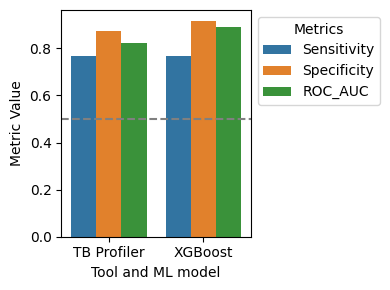

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the combined DataFrame for easier plotting
melted_combined_df = pd.melt(combined_results_UG, id_vars=['Model'],
                              value_vars=['Sensitivity', 'Specificity', 'ROC_AUC'],
                              var_name='Metric', value_name='Value')

# Plotting
plt.figure(figsize=(4,3))
sns.barplot(data=melted_combined_df, x='Model', y='Value', hue='Metric')
#plt.title('Comparison of performance of the ML Models and Existing tools')
plt.ylabel('Metric Value')
plt.xlabel('Tool and ML model')
plt.axhline(0.5, color='gray', linestyle='--')  # Optional: reference line for 0.5
#plt.legend(title='Metrics')
# Move the legend outside of the plot
plt.legend(title='Metrics',loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the coordinates to move the legend
plt.tight_layout()
# Save the plot with high resolution
plt.savefig('EMB_Bench_marking_UG.png', dpi=300)
plt.show()


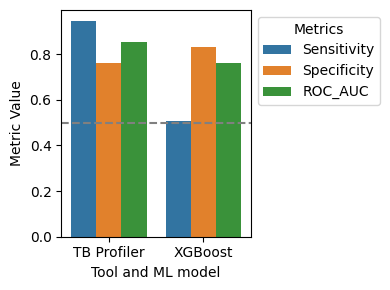

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the combined DataFrame for easier plotting
melted_combined_df = pd.melt(combined_results_SA, id_vars=['Model'],
                              value_vars=['Sensitivity', 'Specificity', 'ROC_AUC'],
                              var_name='Metric', value_name='Value')

# Plotting
plt.figure(figsize=(4, 3))
sns.barplot(data=melted_combined_df, x='Model', y='Value', hue='Metric')
#plt.title('Comparison of performance of the ML Models and Existing tools')
plt.ylabel('Metric Value')
plt.xlabel('Tool and ML model')
plt.axhline(0.5, color='gray', linestyle='--')  # Optional: reference line for 0.5
#plt.legend(title='Metrics')
# Move the legend outside of the plot
plt.legend(title='Metrics',loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the coordinates to move the legend
plt.tight_layout()
# Save the plot with high resolution
plt.savefig('EMB_Bench_marking_SA.png', dpi=300)
plt.show()
